# Speed from data
In this notebook, we'll take a look at a practical matter that arises when we compute derivatives from data.

We'll start with some pretty standard imports.

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.misc import derivative

In addition, we're going to import some XML data off the interwebs and process it a bit.

In [3]:
import xml.etree.ElementTree as ET
from datetime import datetime
import requests

response = requests.get("https://www.marksmath.org/data/LeicesterMarshallRiver.gpx")
response

<Response [200]>

XML stands for eXtensible Markup Language and GPX is a specific extension used to store geographic data. The GPX file we just grabbed came off of my iPhone after I did a bike ride last June. The first few lines look like so:

    <?xml version="1.0" encoding="UTF-8"?>
    <gpx xmlns="http://www.topografix.com/GPX/1/1" version="1.1" 
      creator="Minimalist GPS Tracker">
    	<trk>
    		<name>June 29, 2017 at 12:55:06 PM EDT</name>
    		<trkseg>
    			<trkpt lat="35.604563" lon="-82.566075">
    				<ele>649.002197</ele>
    				<time>2017-06-29T16:55:09Z</time>
    			</trkpt>
    			<trkpt lat="35.604775" lon="-82.566161">
    				<ele>643.687346</ele>
    				<time>2017-06-29T16:55:11Z</time>
    			</trkpt>
    			<trkpt lat="35.604785" lon="-82.566049">
    				<ele>643.924650</ele>
    				<time>2017-06-29T16:55:20Z</time>
    			</trkpt>


It takes a bit of work to parse this, but here it goes:

In [4]:
# Set up to parse the file
tree = ET.ElementTree(ET.fromstring(response.content))
root = tree.getroot()

# Get all the track points
trk = root.find('{http://www.topografix.com/GPX/1/1}trk')
trksegs = trk.findall('{http://www.topografix.com/GPX/1/1}trkseg')
trkpts = []
for trkseg in trksegs:
    trkpts = trkpts + trkseg.findall('{http://www.topografix.com/GPX/1/1}trkpt')

# Extract longitudes and latitudes
lon_pts = [float(trkpt.get('lon')) for trkpt in trkpts]
lat_pts = [float(trkpt.get('lat')) for trkpt in trkpts]

# Get the starting time
start_time = trkpts[0].find('{http://www.topografix.com/GPX/1/1}time')
start_time = datetime.strptime(start_time.text, '%Y-%m-%dT%H:%M:%SZ')

# Arrays to store some info we're going to grab
elevations = []
times = []

# Step through the track points and extract the elevations and times.
for trkpt in trkpts:
    time = trkpt.find('{http://www.topografix.com/GPX/1/1}time')
    time = datetime.strptime(time.text, '%Y-%m-%dT%H:%M:%SZ')
    times.append((time-start_time).seconds)
    elevation = float(trkpt.find('{http://www.topografix.com/GPX/1/1}ele').text)
    elevations.append(elevation)
    
# A little clean up
stop_idx = max(np.nonzero(np.diff(lat_pts))[0][-1],np.nonzero(np.diff(lon_pts))[0][-1])
lon_pts = lon_pts[:stop_idx]
lat_pts = lat_pts[:stop_idx]
elevations = elevations[:stop_idx]
times = times[:stop_idx]

# A function to compute distance from one point to the next
pio180 = np.pi/180
def dist(lat1,lon1, lat2,lon2): 
    return 7920*np.arcsin(np.sqrt(np.sin(pio180*(lat1-lat2)/2)**2 + \
        np.cos(pio180*lat1)*np.cos(pio180*lat2)*np.sin(pio180*(lon1-lon2)/2)**2))

# Step through and get the cummulative distances
distances = [0]
for i in range(len(lat_pts)-1):
    step = dist(lat_pts[i],lon_pts[i], lat_pts[i+1],lon_pts[i+1])
    distances.append(distances[i] + step)

[distances[-1],times[-1]/60**2]

[47.566170368445007, 3.930277777777778]

Looks like, for each time, we know where we are, how far we've gone, and our elevation. We oughtta be able to do some visualization and analysis!

Here's what our path looks like:

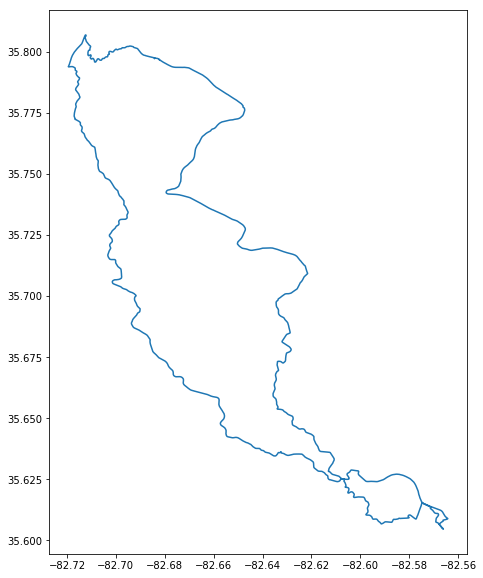

In [5]:
plt.plot(lon_pts,lat_pts)
ax = plt.gca()
ax.set_aspect(1)
fig = plt.gcf()
fig.set_size_inches(10,10)

Might look better [on a map](https://www.marksmath.org/maps/LeicesterMarshallRiver.html)!

Here's an elvation chart:

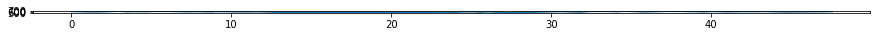

In [26]:
plt.plot(distances,elevations)
ax = plt.gca()
ax.set_aspect(1/2000)
fig = plt.gcf()
fig.set_size_inches(15,15)

OK, let's try to plot the *speed* as a function of time. We've got distance as a function of time - how hard could it be??

Here's distance as a function of time in hours:

In [6]:
hours = [t/60**2 for t in times]
d_of_t = interp1d(hours,distances)

Speed should just be the derivative:

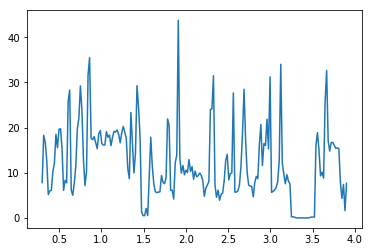

In [16]:
def speed(t): return derivative(d_of_t, t, 0.001)
ts = np.linspace(0.3,3.9,200)
plt.plot(ts,speed(ts))

In [23]:
speed(hours[-1]-0.005)

14.574354645361609

Looks a little rough! A common technique is to smooth the data via averages:

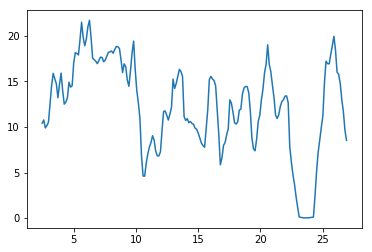

In [25]:
r = 3
speeds = [speed(t) for t in ts]
smooth_speeds = [sum(speeds[k-r:k+r+1])/(2*r+1) for k in range(r,len(speeds)-r)]
smooth_ts = [sum(ts[k-r:k+r+1]) for k in range(r,len(ts)-r)]
plt.plot(smooth_ts,smooth_speeds)